In [97]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import *
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [98]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df.isnull().values.any()
df.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [99]:
df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('Date')
Daily_Price = group['Weighted_Price'].mean()
Daily_Price.head()

Date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

In [115]:
new_df= pd.DataFrame(list(Daily_Price), index = Daily_Price.index, columns = ["Close"])

In [116]:
new_df.head()

,Close
Date,
2011-12-31,4.472579
2012-01-01,4.680778
2012-01-02,5.000000
2012-01-03,5.145917
2012-01-04,5.195443


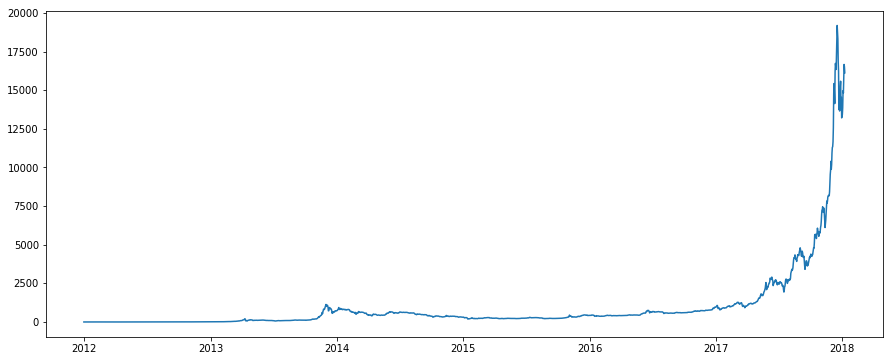

In [117]:
plt.plot(new_df)

In [118]:
# new_df=new_df.asfreq(freq='1D')
len(new_df)

2198

In [119]:
train=new_df[0:2000] 
test=new_df[2000:]
# print(train.tail())
print(test.head())
# print(test.tail())
# np.any(np.isnan(train.Close))

                  Close
Date                   
2017-06-25  2559.189984
2017-06-26  2464.850872
2017-06-27  2407.678633
2017-06-28  2533.627700
2017-06-29  2558.611860


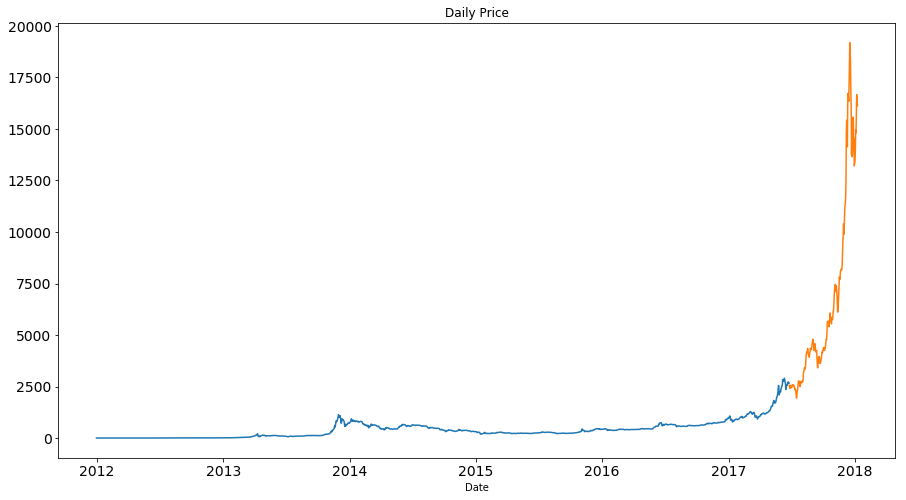

In [120]:
train.Close.plot(figsize=(15,8), title= 'Daily Price', fontsize=14)
test.Close.plot(figsize=(15,8), title= 'Daily Price', fontsize=14)
plt.show()

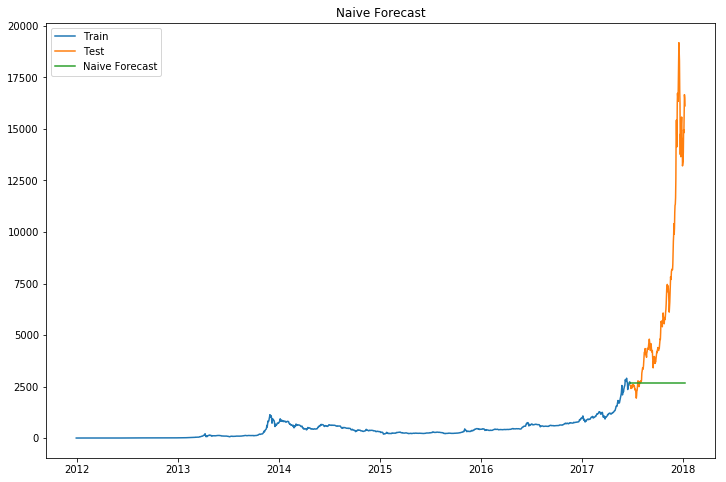

In [121]:
dd= np.asarray(train.Close)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

#ploting Graph between Train test NAIVE Approach for forecast
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index,test['Close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [122]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Close, y_hat.naive))
print(rms)

6035.757317152395


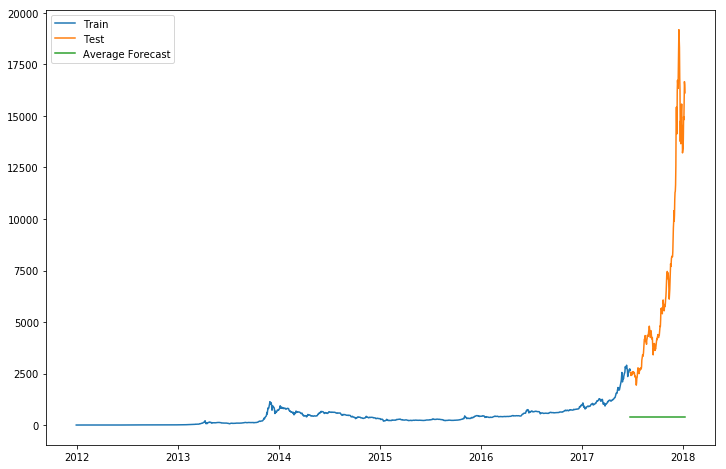

In [123]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Close'].mean()

plt.figure(figsize=(12,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [124]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.avg_forecast))
print(rms)

7702.261889682111


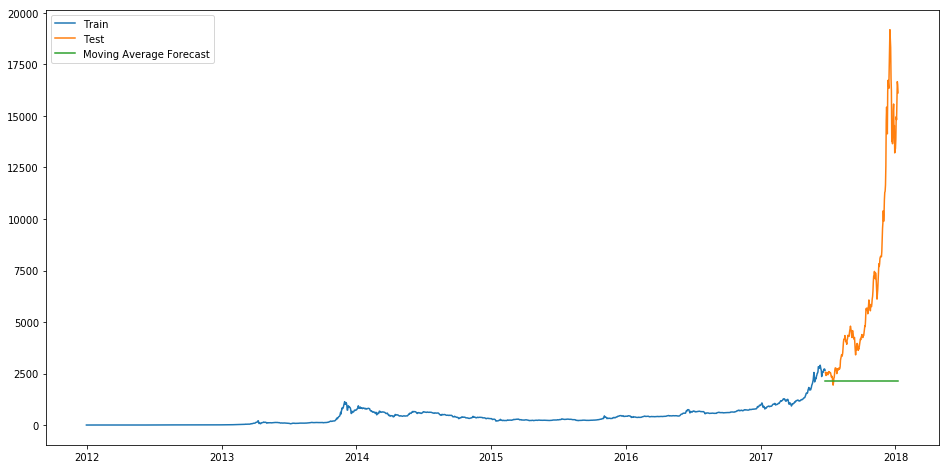

In [135]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(60).mean().iloc[-1]

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [136]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.moving_avg_forecast))
print(rms)

6388.595483626814


In [137]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

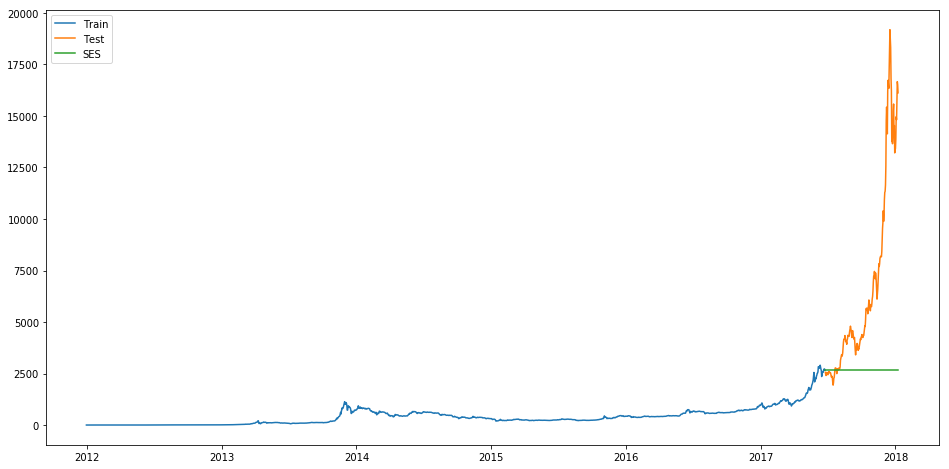

In [138]:
y_hat_avg = test.copy()
# print(y_hat_avg)
fit2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.6,optimized=False)

y_hat_avg['SES'] = fit2.forecast(len(test))
# print(y_hat_avg['SES'])

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [139]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.SES))
print(rms)

6023.882746244405


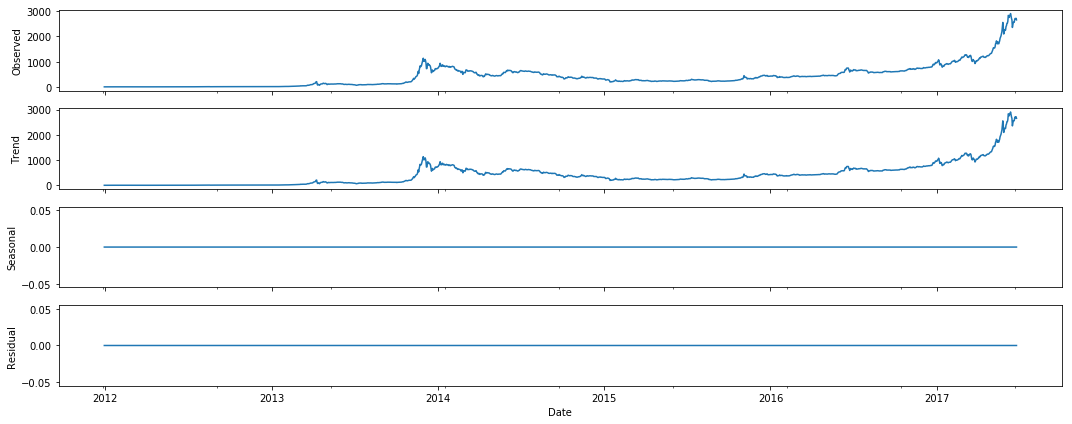

In [140]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Close,freq=1).plot()
result = sm.tsa.stattools.adfuller(train.Close)
plt.show()

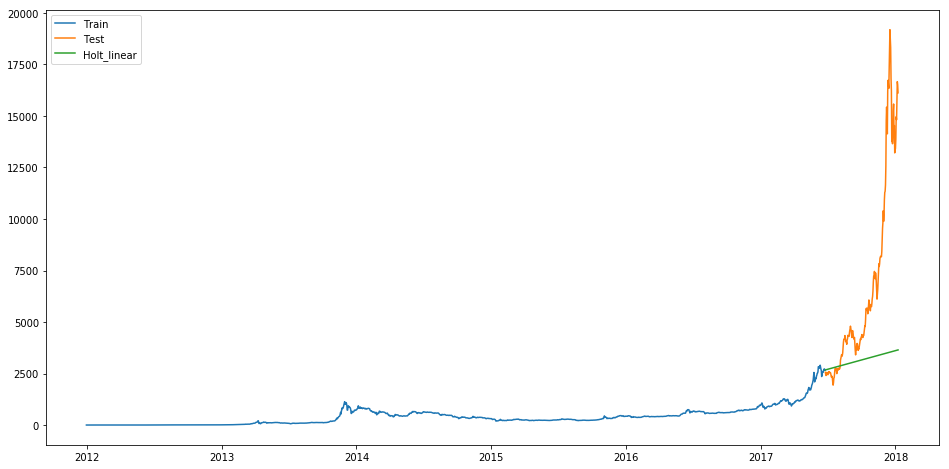

In [141]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [142]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.Holt_linear))
print(rms)

5523.209004475812


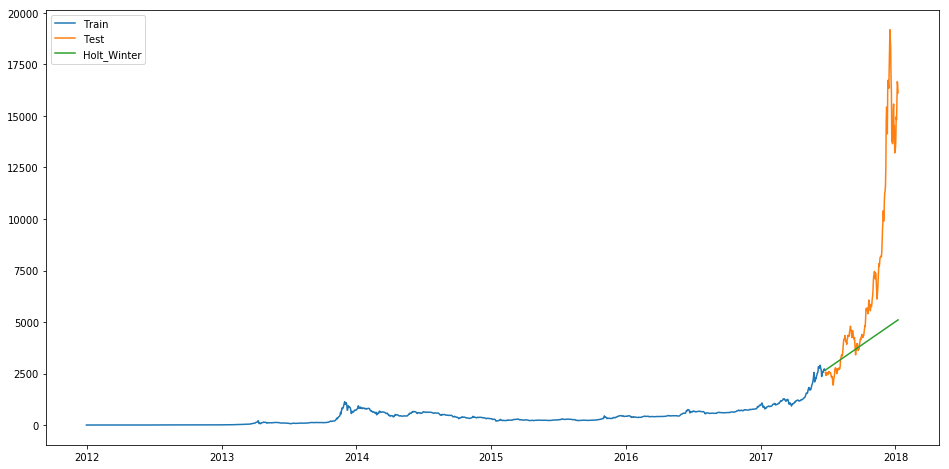

In [143]:
# y_hat_avg = test.copy()
# fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
# y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [144]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.Holt_Winter))
print(rms)

4800.823958339304


In [45]:
# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 2),seasonal_order=(0,1,1,7)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# y_hat_avg = test.copy()
# fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
# y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-04", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 1)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 2),seasonal_order=(-3,0,1,3)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit(disp=-1)
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# plt.figure(figsize=(16,8))
# plt.plot( train['Close'], label='Train')
# plt.plot(test['Close'], label='Test')
# plt.plot(y_hat_avg['SARIMA'], label='SARIMA',linewidth=3)
# plt.legend(loc='best')
# plt.show()

In [46]:
# rms = sqrt(mean_squared_error(test.Close, y_hat_avg.SARIMA))
# print(rms)